In [16]:
# ==============================================================
# 1️⃣ IMPORT LIBRARIES
# ==============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ==============================================================
# 2️⃣ LOAD & CLEAN DATA
# ==============================================================
df = pd.read_csv("stroke.csv")
df = df.drop(columns=["id", "Residence_type", "gender"], errors="ignore")
df = df.drop_duplicates().dropna()

# Merge work_type & encode
df["work_type"] = df["work_type"].replace({
    "children": "Child_Neverwork",
    "Never_worked": "Child_Neverwork"
})
df["ever_married"] = df["ever_married"].map({"Yes": 1, "No": 0})

# ==============================================================
# 3️⃣ FEATURE ENGINEERING (giống logistic & SVM)
# ==============================================================
df["age_glucose_interaction"] = df["age"] * df["avg_glucose_level"]
df["age_bmi_interaction"] = df["age"] * df["bmi"]
df["high_risk"] = ((df["hypertension"] == 1) | (df["heart_disease"] == 1)).astype(int)

# ==============================================================
# 4️⃣ SPLIT DATA (Train 60%, Val 20%, Test 20%)
# ==============================================================
X = df.drop(columns=["stroke"])
y = df["stroke"]

# Step 1: hold-out test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

# Step 2: validation 20% (of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# ==============================================================
# 5️⃣ DEFINE PREPROCESSING for EACH MODEL
# ==============================================================

# --- Logistic Regression ---
num_cols_logis = ['age', 'avg_glucose_level', 'bmi',
                  'age_glucose_interaction', 'age_bmi_interaction']
bin_cols_logis = ['high_risk', 'hypertension', 'heart_disease', 'ever_married']
cat_cols_logis = ['work_type', 'smoking_status']

pre_logis = ColumnTransformer([
    ('num', StandardScaler(), num_cols_logis),
    ('bin', 'passthrough', bin_cols_logis),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_logis)
])

logistic_pipe = Pipeline([
    ('pre', pre_logis),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=200,
        random_state=42
    ))
])

# --- SVM ---
num_cols_svm = num_cols_logis
bin_cols_svm = bin_cols_logis
cat_cols_svm = cat_cols_logis

pre_svm = ColumnTransformer([
    ('num', StandardScaler(), num_cols_svm),
    ('bin', 'passthrough', bin_cols_svm),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_svm)
])

svm_pipe = Pipeline([
    ('pre', pre_svm),
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('model', SVC(kernel='rbf', gamma=0.001, C=1.0,
                  class_weight='balanced', probability=True, random_state=42))
])

# --- XGBOOST ---
# XGBoost dùng dữ liệu gốc (không interaction, không high_risk)
df_xgb = df.drop(columns=["age_glucose_interaction", "age_bmi_interaction", "high_risk"])
df_xgb["work_type"] = df_xgb["work_type"].astype("category")
df_xgb["smoking_status"] = df_xgb["smoking_status"].astype("category")
df_xgb["ever_married"] = df_xgb["ever_married"].astype("category")

X_xgb = df_xgb.drop(columns=["stroke"])
y_xgb = df_xgb["stroke"]

X_temp_xgb, X_test_xgb, y_temp_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.20, stratify=y_xgb, random_state=42)

X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_temp_xgb, y_temp_xgb, test_size=0.25, stratify=y_temp_xgb, random_state=42)

xgb_pipe = Pipeline([
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
        enable_categorical=True,  # sử dụng native categorical
        tree_method='hist',      # bắt buộc
        scale_pos_weight=10,
        subsample=0.8,
        colsample_bytree=1.0,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=200
    ))
])

# ==============================================================
# 6️⃣ TRAIN BASE MODELS
# ==============================================================
logistic_pipe.fit(X_train, y_train)
svm_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train_xgb, y_train_xgb)

# ==============================================================
# 7️⃣ META TRAINING DATA (Validation)
# ==============================================================
val_prob_logis = logistic_pipe.predict_proba(X_val)[:, 1]
val_prob_svm = svm_pipe.predict_proba(X_val)[:, 1]
val_prob_xgb = xgb_pipe.predict_proba(X_val_xgb)[:, 1]

meta_X = np.column_stack([val_prob_logis, val_prob_svm, val_prob_xgb])
meta_y = y_val

meta_model = LogisticRegression(class_weight='balanced', max_iter=500)
meta_model.fit(meta_X, meta_y)


# ==============================================================
# 8️⃣ FINAL EVALUATION ON TEST
# ==============================================================
test_prob_logis = logistic_pipe.predict_proba(X_test)[:, 1]
test_prob_svm = svm_pipe.predict_proba(X_test)[:, 1]
test_prob_xgb = xgb_pipe.predict_proba(X_test_xgb)[:, 1]

test_meta_X = np.column_stack([test_prob_logis, test_prob_svm, test_prob_xgb])
final_pred = meta_model.predict_proba(test_meta_X)[:, 1]

print("\n=== ENSEMBLE TEST EVALUATION ===")
print("ROC-AUC:", roc_auc_score(y_test, final_pred))
print(classification_report(y_test, (final_pred > 0.3).astype(int)))


Train=2945, Val=982, Test=982

=== ENSEMBLE TEST EVALUATION ===
ROC-AUC: 0.8168693009118541
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       940
           1       0.09      0.79      0.17        42

    accuracy                           0.66       982
   macro avg       0.54      0.72      0.48       982
weighted avg       0.95      0.66      0.76       982



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix, roc_curve
import numpy as np

def evaluate_split(y_true, y_proba, threshold=0.5, name="Split"):
    y_pred = (y_proba >= threshold).astype(int)
    roc_auc = roc_auc_score(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(rec, prec)
    print(f"\n=== {name} ===")
    print(f"Threshold={threshold:.2f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f"Confusion Matrix - {name} (thr={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [18]:
def plot_prob_distributions(y_true, y_proba, threshold=0.5):
    no_stroke_probs = y_proba[y_true == 0]
    stroke_probs = y_proba[y_true == 1]

    no_stroke_pred_below_thr = no_stroke_probs[no_stroke_probs < threshold]
    no_stroke_pred_above_thr = no_stroke_probs[no_stroke_probs >= threshold]
    stroke_pred_below_thr = stroke_probs[stroke_probs < threshold]
    stroke_pred_above_thr = stroke_probs[stroke_probs >= threshold]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    bins = np.linspace(0, 1, 30)

    sns.histplot(no_stroke_pred_below_thr, bins=bins, color='blue', label='TN', ax=axes[0], alpha=0.7)
    sns.histplot(no_stroke_pred_above_thr, bins=bins, color='red', label='FP', ax=axes[0], alpha=0.7)
    axes[0].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axes[0].set_xlim(0, 1)
    axes[0].set_title('Predicted Probabilities for True No Stroke Cases')
    axes[0].set_xlabel('Predicted Probability of Stroke')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    sns.histplot(stroke_pred_below_thr, bins=bins, color='red', label='FN', ax=axes[1], alpha=0.7)
    sns.histplot(stroke_pred_above_thr, bins=bins, color='blue', label='TP', ax=axes[1], alpha=0.7)
    axes[1].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axes[1].set_xlim(0, 1)
    axes[1].set_title('Predicted Probabilities for True Stroke Cases')
    axes[1].set_xlabel('Predicted Probability of Stroke')
    axes[1].set_ylabel('Count')
    axes[1].legend()

    plt.tight_layout()
    plt.show()



=== Ensemble ===
Threshold=0.30, ROC-AUC=0.8169, PR-AUC=0.2250
              precision    recall  f1-score   support

           0     0.9857    0.6596    0.7903       940
           1     0.0935    0.7857    0.1671        42

    accuracy                         0.6650       982
   macro avg     0.5396    0.7226    0.4787       982
weighted avg     0.9475    0.6650    0.7637       982



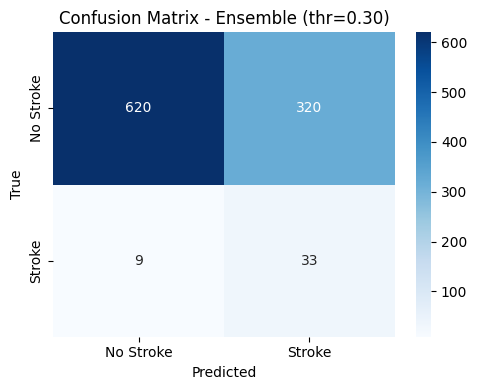

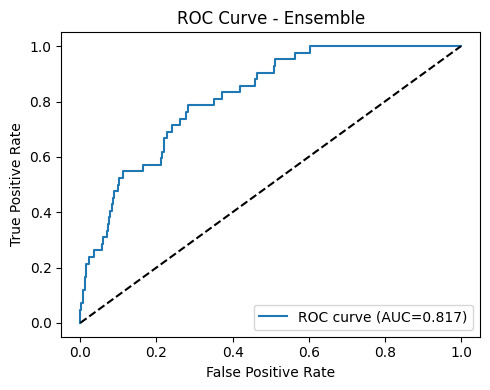

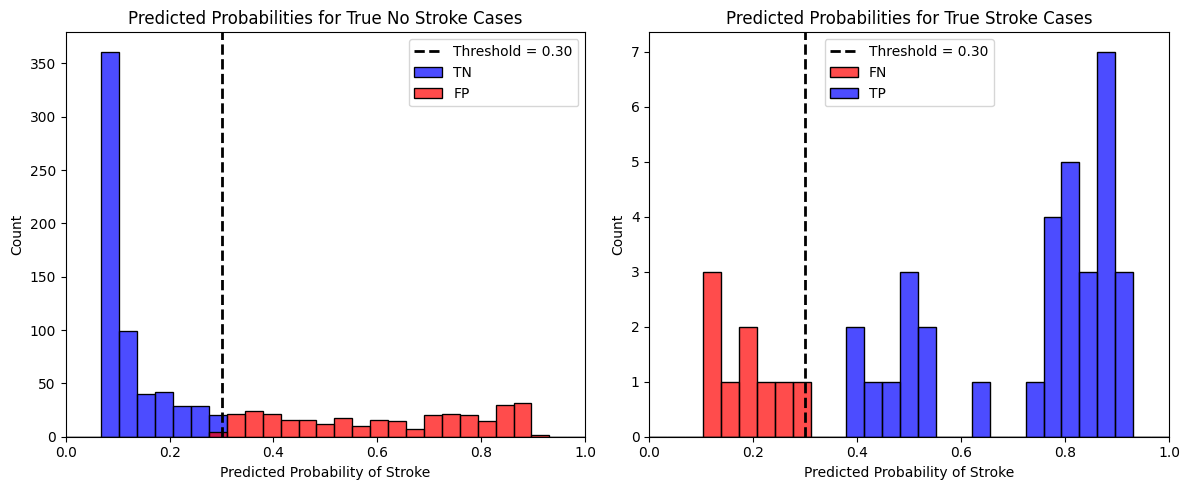

In [19]:
evaluate_split(y_test, final_pred, threshold=0.3, name="Ensemble")
plot_prob_distributions(y_test, final_pred, threshold=0.3)